In [1]:
!pip install -q sklearn

In [2]:
%tensorflow_version 2.x 

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [10]:
train_data = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
test_data = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/eval.csv")

In [11]:
train_data.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [12]:
test_data.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,35.0,0,0,8.0500,Third,unknown,Southampton,y
1,0,male,54.0,0,0,51.8625,First,E,Southampton,y
2,1,female,58.0,0,0,26.5500,First,C,Southampton,y
3,1,female,55.0,0,0,16.0000,Second,unknown,Southampton,y
4,1,male,34.0,0,0,13.0000,Second,D,Southampton,y


In [13]:
train_data_survived = train_data.pop('survived')
test_data_survived = test_data.pop('survived')

In [14]:
train_data.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


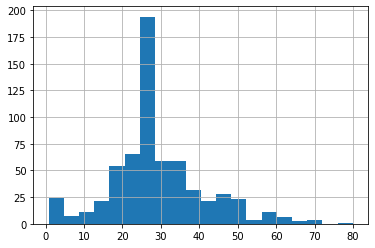

In [23]:
train_data.age.hist(bins=20)

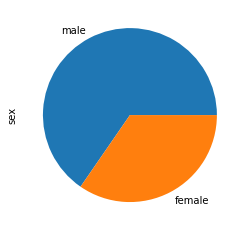

In [27]:
train_data['sex'].value_counts().plot(kind='pie')

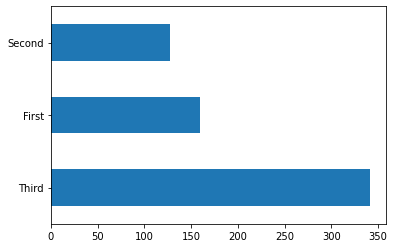

In [32]:
train_data['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% of survival')

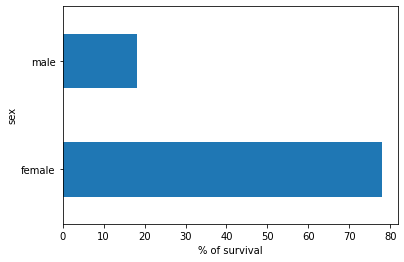

In [50]:
percentage_survival = pd.concat([train_data, train_data_survived], axis=1).groupby('sex').survived.mean() * 100
percentage_survival.plot(kind='barh').set_xlabel('% of survival')

In [53]:
train_data.iloc[0]

sex                          male
age                            22
n_siblings_spouses              1
parch                           0
fare                         7.25
class                       Third
deck                      unknown
embark_town           Southampton
alone                           n
Name: 0, dtype: object

In [56]:
CATEGORY_COLS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLS = ['age', 'fare']

feature_cols = []
for feature_name in CATEGORY_COLS:
  vocabulary = train_data[feature_name].unique()
  feature_cols.append(tf.feature_column.categorical_column_with_vocabulary_list(key=feature_name, vocabulary_list=vocabulary))

for feature_name in NUMERIC_COLS:
  feature_cols.append(tf.feature_column.numeric_column(key=feature_name, dtype=tf.float32))

In [57]:
feature_cols

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

In [60]:
def make_input_func(df_data, df_label, suffle=True, batch_size=32, no_of_epoch=10):
  def input_func():
    ds = tf.data.Dataset.from_tensor_slices((dict(df_data), df_label))

    if suffle:
      ds = ds.shuffle(1000)
    
    ds = ds.batch(batch_size=batch_size).repeat(no_of_epoch)
    return ds

  return input_func

In [62]:
train_input_func = make_input_func(df_data=train_data, df_label=train_data_survived)
test_input_func = make_input_func(df_data=test_data, df_label=test_data_survived, suffle=False, no_of_epoch=1)

In [63]:
linear_est_model = tf.estimator.LinearClassifier(feature_columns=feature_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpec40hfgp', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [65]:
linear_est_model.train(input_fn=train_input_func)

result = linear_est_model.evaluate(input_fn=test_input_func)

clear_output()
result

{'accuracy': 0.77272725,
 'accuracy_baseline': 0.625,
 'auc': 0.83318025,
 'auc_precision_recall': 0.7881006,
 'average_loss': 0.473887,
 'global_step': 400,
 'label/mean': 0.375,
 'loss': 0.46224293,
 'precision': 0.7294118,
 'prediction/mean': 0.35158452,
 'recall': 0.6262626}

Text(0.5, 0, 'Probabilities')

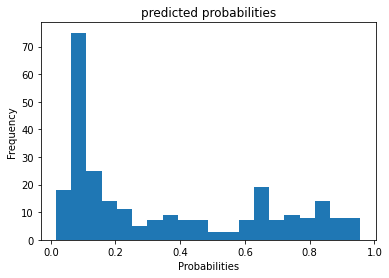

In [89]:
predictions = pd.Series(linear_est_model.predict(input_fn=test_input_func))
survival_probalities = pd.Series(prediction['probabilities'][1] for prediction in predictions)

clear_output()
survival_probalities.plot(kind='hist', bins=20, title='predicted probabilities').set_xlabel('Probabilities')